<a href="https://colab.research.google.com/github/Crippius/al_project/blob/main/al_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from keras import backend as K
from sentence_transformers import SentenceTransformer
import keras
from google.colab import drive

import math
import h5py

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Auxiliary methods
%%capture

# Metrics used by model, necessary to specify when loading model

# Recall: ability to identify all relevant instances (TP / TP + FN)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision: ability to distinguish relevant instances from others (TP / TP + FP)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1: mean of precision and recall (2*precision*recall / precision+recall)
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

keras.utils.get_custom_objects()['recall_m'] = recall_m
keras.utils.get_custom_objects()['precision_m'] = precision_m
keras.utils.get_custom_objects()['f1_m'] = f1_m

EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

def embed_text(txt):
  return EMBEDDING_MODEL.encode(txt)

# Default: 0.5
DECISION_THRESHOLD = 0.50
# Default: 0.1
CLASSIFICATION_THRESHOLD = 0.1


def decision(cnn_output):
  return cnn_output > DECISION_THRESHOLD

def classify(label):
  return label > CLASSIFICATION_THRESHOLD

In [ ]:
# @title Methods to read .h5 file

def get_metadata(file):
  with h5py.File(file, 'r') as f:

    dataset = f['parameters']

    metadata = {}
    for i, j in dataset.items():
      metadata[i] = j[()]

  return metadata


def get_metrics(file):
  with h5py.File(file, 'r') as f:

    dataset = f['metrics']

    metrics = {}
    for i, j in dataset.items():
      metrics[i] = j[()]

  return metrics


def diff_metadata(meta1, meta2):
  for i in meta1.keys():
    if meta1[i] != meta2[i]:
      print(f"{i}:\n1 -> {meta1[i]}\n2->{meta2[i]}")



In [ ]:
# @title Model class

class Model:
    def __init__(self, name:str):
        self.name = name
        self.path = f"/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/al_project/models/{name}.h5"
        self.metadata = get_metadata(self.path)
        self.metrics = get_metrics(self.path)
        self.tf_adapter = tf.keras.models.load_model(self.path)

    def __str__(self):
        return self.name

    def get_metrics(self):
        return self.metrics

    def print_metadata(self):
        print(f"{self.name.title()} model metadatata")
        for i, j in self.metadata.items():
          print(f"{i} : {j}")

    def get_data(self, metric:str):
        if metric in self.metrics:
            return self.metrics[metric]
        return []

    def plot_data(self, metric:str):
      if metric not in self.metrics:
          print("Metric not found")
          return

      plt.plot(self.get_data(metric))
      plt.title(f'{self.name} model {metric}')
      plt.ylabel('Performance metrics')
      plt.plot()

    def compare_data(self, metric: str, *others: 'Model'):
        if metric not in self.metrics or any(metric not in other.metrics for other in others):
            print("Metric not found")
            return

        plt.plot(self.get_data(metric), label=self.name)
        for other in others:
            plt.plot(other.get_data(metric), label=other.name)

        plt.title(f'Model comparison on {metric}')
        plt.ylabel('Performance metrics')
        plt.legend(loc='lower right')
        plt.show()

    def compare_all_data(self, *others: 'Model'):
      custom_order = ['train_accuracy', 'precision', 'recall', 'f1']
      comparable_metrics = sorted([metric for metric in self.metrics if all(metric in other.metrics for other in others)], key=lambda x: custom_order.index(x))
      fig, axs = plt.subplots(1, len(comparable_metrics), figsize=(16, 4))
      axs = axs.flatten()

      for i in range(len(comparable_metrics)):


          axs[i].plot(self.metrics[comparable_metrics[i]], label=self.name)
          for other in others:
              axs[i].plot(other.metrics[comparable_metrics[i]], label=other.name)

          axs[i].set_title(comparable_metrics[i])
          axs[i].set_ylim(0, 1)
          axs[i].legend(loc='lower right')


      plt.tight_layout()
      plt.show()



    def predict(self, data):
        return self.tf_adapter.predict(data)


In [ ]:
models = ["default",
          "random",
          "farthest_first",
          "optimal",
          "forgetful",
          "10_budget",
          "100_budget",
          "e-4",
          "e-5",
          "decision_0.25",
          "decision_0.75",
          "classification_0.9",
          # "0.5_days"
          # "2_days",
          # "all_data",
          ]

models = [Model(i) for i in models]

In [ ]:
figure_side = math.ceil(math.sqrt(len(models)))

fig, axs = plt.subplots(figure_side, figure_side)
metric = "f1"


# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

# Plot on each subplot
for i in range(len(models)):
    axs[i].plot(models[i].metrics[metric])
    axs[i].set_title(models[i])
    axs[i].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

metric = "f1"

# Plot on each subplot
for i in range(len(models)):
    plt.plot(models[i].metrics[metric])
    plt.ylim(0, 1)

plt.legend([str(i) for i in models])
plt.show()


# Model comparisions

## Active Learning methods comparison

In [ ]:
default = Model("default")

default.compare_all_data(Model("random"), Model("farthest_first"))

When comparing the results between the two core-set methods, the approximate version and the real one, they appear quite similar. \\
However, random sampling of labels yields different outcomes: the training accuracy doesn't keep pace with the active learning methods as the model trains on more labels. \\
Yet, when evaluating the results against the training set, the differences between methods seems mostly negligible.

## Active Learning efficiency comparison

In [ ]:
default = Model("default")

default.compare_all_data(Model("forgetful"), Model("optimal"))


These plots illustrate the performance of the current implementation compared to the optimal approach, where the model is trained on every label of the current timeframe, and the forgetful approach, which only considers the budgeted labels of the current timeframe, serving as a lower bound. \\
The forgetful option isn't comparable to the other ones, as its lack of data each timeframe leads to models with unsatisfying results. \\
When comparing the optimal model with the normal one, it's evident that while the former exhibits lower training accuracy and a similar precision ratio, it surpasses the normal model with a higher recall, avoiding most false negatives.

## Total budget comparison

In [ ]:
default = Model("default")

default.compare_all_data(Model("10_budget"), Model("100_budget"))


The quality of a neural network is proportional to the size of the training data it can analyze, as evidenced by the results. \\
The model utilizing 1000 labels outperformed the others significantly, demonstrating improved performance with each timeframe. \\
Conversely, models with 10 and 100 labels per timeframe suffered from data scarcity, leading to instances of indiscriminate decision-making, such as classifying everything positively or negatively.

## Learning rate comparison

In [ ]:
default = Model("default")

default.compare_all_data(Model("e-4"), Model("e-5"))


The results here are clear: a higher learning rate leads to better results. \\
Because of the scarcity of data and the limited number of epochs, models with lower learning rates lack the resources to effectively optimize their weights, particularly impacting their precision performance.

## Decision threshold comparison

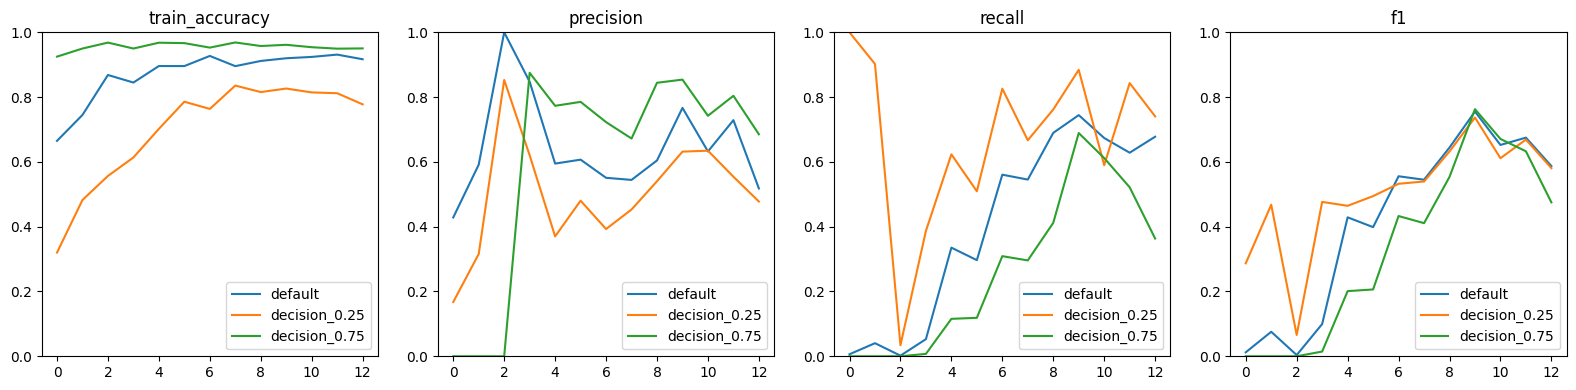

In [13]:
default = Model("default")

default.compare_all_data(Model("decision_0.25"), Model("decision_0.75"))


As expected, the position of the decision threshold is directly proportional to the model's precision and inversely proportional to its recall. \\
Ultimately, the F1 values for each decision threshold are mostly similar.

## Classification threshold comparison

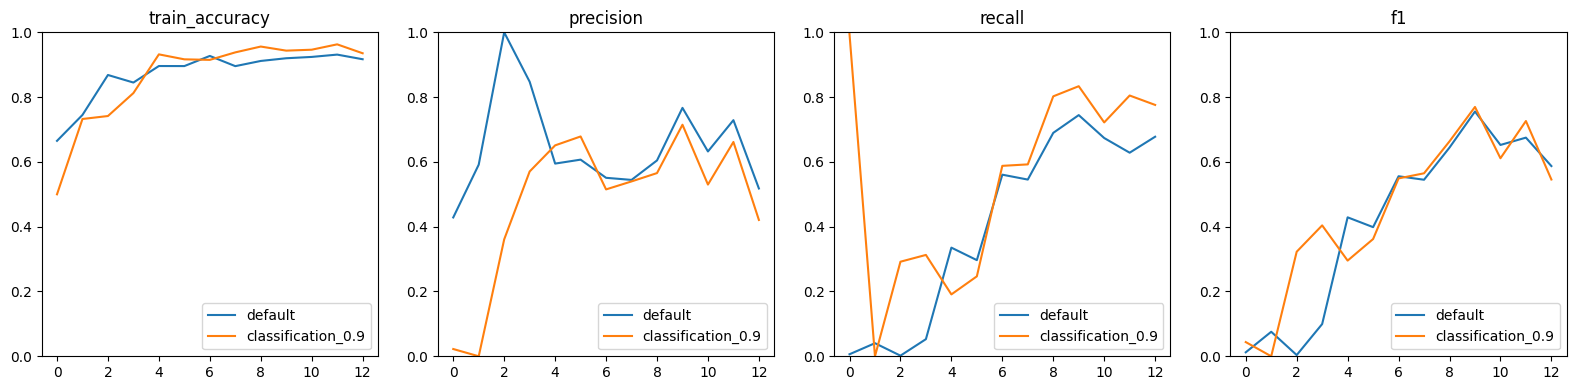

In [14]:
default = Model("default")

default.compare_all_data(Model("classification_0.9"))


By utilizing a higher classification threshold, only the most certain positive labels are included, eliminating ambiguity. While this strategy reduces false negatives, it also compromises the model's precision. Analogous to the decision threshold, the F1 values for each classification threshold are predominantly similar.

## Timeframe comparison

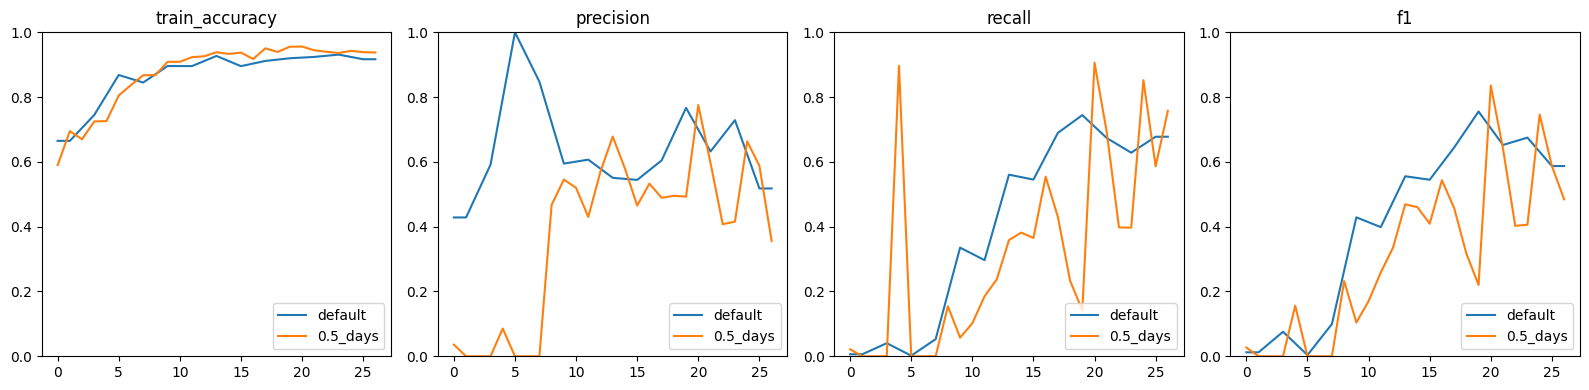

In [15]:
default = Model("default")
other = Model("0.5_days")

fig, axs = plt.subplots(1, len(default.get_metrics()), figsize=(16, 4))
axs = axs.flatten()

custom_order = ['train_accuracy', 'precision', 'recall', 'f1']
metrics = sorted(default.get_metrics().items(), key=lambda x: custom_order.index(x[0]))

for i, metric_elem in enumerate(metrics):
  metric, data = metric_elem

  # Adapting data to have same timeframe
  adapted_data = []
  adapted_data.append(data[0])
  for el in range(len(data)-1):
    adapted_data.append(data[el])
    adapted_data.append((data[el]+data[el+1])/2)
  adapted_data.append(data[-1])
  adapted_data.append(data[-1])

  axs[i].plot(adapted_data, label=default)
  axs[i].plot(other.get_data(metric), label=other.name)
  axs[i].set_title(metric)
  axs[i].set_ylim(0, 1)
  axs[i].legend(loc='lower right')

plt.tight_layout()
plt.show()


When using a smaller timeframe (while having the same throughput), the first models have a very bad performance, but as time goes on its values start getting more similar to the ones with a higher time gap. \\
The final test data is also seemingly less stable then the default one.

# Custom examples

In [16]:


examples = {"Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" : 1.0,
            "Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies" : 0.0,
            "Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1" : 0.0,
            "Inter Milano has defeated Dynamo Kiev once again! What a slaughter! ⚽️🔵⚫️" : 0.0,
            "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" : 1.0,
}

for text_example, label in examples.items():

  encoded_text = [embed_text(text_example)]
  encoded_text = np.array(encoded_text)

  output = default.predict(encoded_text)[0][0]

  print(f"Text: {text_example}\nDesired output: {decision(label)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 139ms/step
Text: Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll
Desired output: True
Actual output: True (0.9373587965965271)
1/1 [==============================] - 0s 22ms/step
Text: Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies
Desired output: False
Actual output: False (0.02415004000067711)
1/1 [==============================] - 0s 23ms/step
Text: Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1
Desired output: False
Actual output: False (0.4124111235141754)
1/1 [==============================] - 0s 25ms/step
Text: Inter Milano has defeated Dynamo Kiev once again! What a slaughter! ⚽️🔵⚫️
Desired output: False
Actual output: False (0.05071515589952469)
1/1 [==============================] - 0s 23ms/step
Text: Thoughts with Palestine during this diffi

In [17]:
# @title Try it out!

MODEL = "e-5" # @param ["default", "random", "farthest_first", "optimal", "forgetful", "10_budget", "100_budget", "e-4", "e-5", "decision_0.25", "decision_0.75", "classification_0.9", "0.5_days", "2_days", "all_data"]
MODEL = Model(MODEL)

TWEET = "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" # @param {type:"string"}
EXPECTED_RESULT = True # @param {type:"boolean"}
encoded_text = [embed_text(TWEET)]
encoded_text = np.array(encoded_text)

output = MODEL.predict(encoded_text)[0][0]

print(f"Text: {TWEET}\nDesired output: {decision(EXPECTED_RESULT)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 150ms/step
Text: Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace
Desired output: True
Actual output: True (0.5596508383750916)
